In [6]:
import powerlaw

In [7]:
powerlaw.Fit??

In [1]:
from net_analysis import *

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter
import powerlaw
from networkx.drawing.nx_agraph import graphviz_layout
import pickle
from statistics import mean, stdev
import seaborn as sns

In [2]:
path = "../DataSet StackOverflow/edges.csv"

In [3]:
path_graph = "../DataSet StackOverflow/Graph_data/"

# 1 - Real World network analysis

- Read unidirect network: <br>
  for a unidirect network: <br>
      average degree < k > = 2L/N

In [4]:
G = nx.read_edgelist(path, comments = "S", delimiter = ",", data=(("Count", int),))

In [5]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 13780
Number of edges: 97892
Average degree:  14.2078


In [6]:
nx.write_graphml(G, path_graph+"Real_Network.graphml")

- Maximum number of edges that a unidirect graph can contain: <br>
      Lmax = N(N-1)/2

In [7]:
N = G.number_of_nodes()
print("LMAX: ", (N * (N-1))/2.0)

LMAX:  94937310.0


- Mean degree: <br/>
    < k > = 2*L/N

In [8]:
avg_degree=(2*G.number_of_edges())/N
avg_degree

14.207837445573295

- Network density: <br>
      d(G) = L/Lmax

In [9]:
density = nx.density(G)
print("Density: ", density)

Density:  0.0010311225375987587


- For sparse network: <br>
            L << Lmax     
            < k > << N-1  
            d(G) << 1     

- Top 10 nodes by degree

In [6]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key = itemgetter(1), reverse = True)
print(" ---- Top 20 nodes by degree ----")
for d in sorted_degree[:20]:
    print("\t" + str(d))

 ---- Top 20 nodes by degree ----
	('python', 2784)
	('javascript', 2291)
	('java', 2036)
	('android', 1676)
	('c++', 1397)
	('c#', 1389)
	('reactjs', 1142)
	('node.js', 1015)
	('python-3.x', 1010)
	('ios', 948)
	('r', 879)
	('swift', 817)
	('flutter', 816)
	('typescript', 788)
	('docker', 773)
	('angular', 762)
	('c', 762)
	('html', 745)
	('php', 693)
	('kotlin', 633)


In [16]:
len(sorted_degree)

13780

In [35]:
example_path = nx.shortest_path(G, source = "adal.js", target = "elmo")
example_path

['adal.js', 'javascript', 'nlp', 'elmo']

- Number of selfloops:

In [11]:
print("Number of selfloops:",nx.number_of_selfloops(G))

Number of selfloops: 0


- Average clustering coefficient:

In [12]:
print("Avg Clustering coefficient:", nx.average_clustering(G))

Avg Clustering coefficient: 0.698890718451805


- Check if the network is connected

In [13]:
print("Is connected: ", nx.is_connected(G))

Is connected:  False


# 2 - Models construction
- Barabási-Albert (scale-free - preferential attachment): <br>
  Function networkx.barabasi_albert_graph(n, m, seed) return a random graph according to the Barabàsi-Albert preferential attachment model. <br> A graph of n nodes is grown by attaching new nodes each with m edges that are preferentially attached to existing nodes with high degree. Where 1 <= m < n
  
- Growth: While the random network model assumes that the number of nodes is fixed (time invariant), real networks are the result of a growth process that continuously increases.

- Preferential Attachment: While nodes in random networks randomly choose their interaction partner, in real networks new nodes prefer to link to the more connected nodes.

In [9]:
ba_G = nx.read_graphml(path_graph+"BA_Network.graphml")

In [10]:
#ba_G = nx.barabasi_albert_graph(G.number_of_nodes(), 10, seed = 42)
print("Nodes:",ba_G.number_of_nodes())
print("Edges:",ba_G.number_of_edges())

Nodes: 13780
Edges: 96411


- Watts-Strogatz (small-world): <br>
  Function watts_strogatz_graph(n, k, p, seed=None) return a Watts-Strogatz small-world graph. Where k = Each node is connected to k nearest neighbors in ring topology; p = The probability of rewiring each edge
  
A model to capture large clustering coefficient and short distances observed in real networks.
From regular lattice (p=0) <br>
..to random netwroks (p=1).. <br>
.. passing by the small world regime (0.001 < p < 0.1)

In [11]:
ws_G = nx.read_graphml(path_graph+"WS_Network.graphml")

In [12]:
#ws_G = nx.watts_strogatz_graph(G.number_of_nodes(), k=20, p=0.1, seed = 42)
print("Nodes:",ws_G.number_of_nodes())
print("Edges:",ws_G.number_of_edges())

Nodes: 13780
Edges: 96460


- Erdös–Rényi (random): <br>
  Function networkx.erdos_renyi_graph(n, p, seed=None, directed=True) return a random graph. The model chooses each of the possible edges with probability p.

A random graph is a graph of N nodes where each pair of nodes is connected by probability p.
ER Regimes:
    - Subcritical: regime <1, p < pc = 1/N
    - Critical regime = 1, p=pc=1/N
    - Supercritical regime ( > 1, p > pc=1/N )
    - Connected regime ( > ln N, p > (ln N)/N)


In [13]:
er_G = nx.read_graphml(path_graph+"ER_Network.graphml")

In [14]:
#er_G = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())
print("Nodes:", er_G.number_of_nodes())
print("Edges:", er_G.number_of_edges())

Nodes: 13780
Edges: 97895


- Configuration model: <br>
  creation Unidirected Configuration Model

In [15]:
cmodel = nx.read_graphml(path_graph+"CM_Network.graphml")

In [16]:
print("Nodes:", cmodel.number_of_nodes())
print("Edges:", cmodel.number_of_edges())

Nodes: 13780
Edges: 97892


In [17]:
models = {"Real Network": G,
          "Barabasi Albert": ba_G, 
          "Watts Strogatz": ws_G, 
          "Erdos Renyi": er_G, 
          "Configuration Model": cmodel
         }

# 3 - Degree Distribution

Visualize the digree distribution

In [15]:
def degree_dist(G, name):
    hist = nx.degree_histogram(G)
    plt.plot(range(0, len(hist[4:])), hist[4:], ".")
    plt.title(f"Degree Distribution for {name} graph")
    plt.xlabel("Degree")
    plt.ylabel("P(k)")
    plt.loglog()
    plt.show()

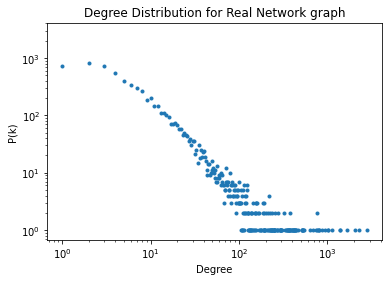

In [16]:
degree_dist(models["Real Network"], "Real Network")

Degree distribution with powerlaw fit

Calculating best minimal value for power law fit
c:\users\matte\.conda\envs\ambiente_con_librerie\lib\site-packages\powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /
c:\users\matte\.conda\envs\ambiente_con_librerie\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
C:\Users\matte\AppData\Local\Temp/ipykernel_14980/1476194936.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim((min(degree), max(degree)))
c:\users\matte\.conda\envs\ambiente_con_librerie\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


**** Degree Distribution for Real Network graph ****


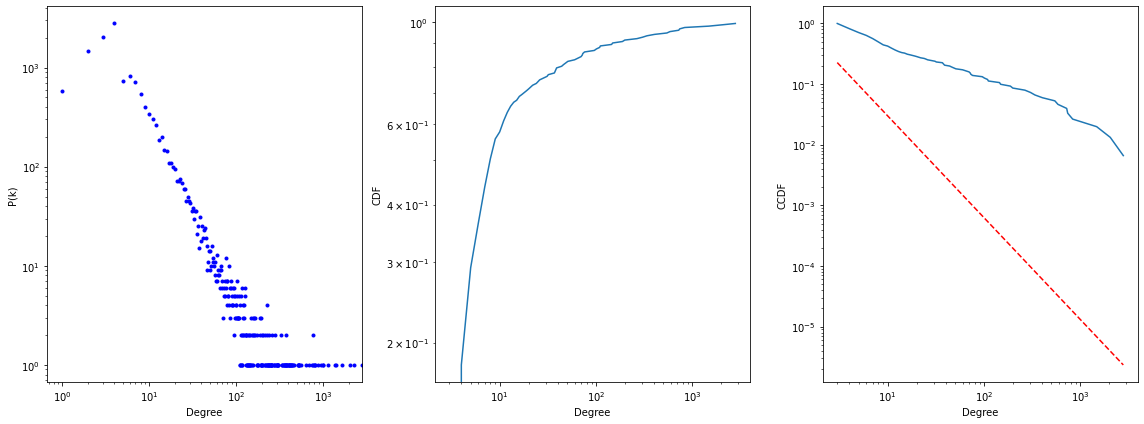

alpha=2.6791751614249097 sigma=0.05527049078516307


In [18]:
plot_dist(models["Real Network"], "Real Network")

Degree info

In [33]:
def info_degree(G, name):
    print(f"***** Degree info for {name} graph ***")
    degree_sequence = sorted([(d, n) for n, d in G.degree()], reverse=True)
    dmax = max(degree_sequence)
    print("Maximum degree:", dmax)
    dmin = min(degree_sequence)
    print("Minimum degree:", dmin)

In [34]:
info_degree(models["Real Network"], "Real Network")

***** Degree info for Real Network graph ***
Maximum degree: (2784, 'python')
Minimum degree: (1, '.d.ts')


Degree distribution plot

In [19]:
def degree_dist_plot(models):
    graphs = []
    for model in models:
        graphs.append((models[model], model))
    fig = plt.figure(figsize=(16,8), dpi= 300)
    labels = []
    for i in graphs:
        print(f"Network - {i[1]}")
        degrees = i[0].degree()
        values = sorted(set([v for k, v in degrees]))
        hist = [[v for k, v in degrees].count(x) for x in values]
        labels.append(i[1])
        if(i[1] == "Real Network"):
            plt.loglog(values, hist, 'o-')
        else:
            plt.loglog(values, hist, 'o')
    fontsize = 15
    plt.yticks(fontsize=fontsize, alpha=1)
    plt.xlabel("Degree", fontsize=fontsize)
    plt.ylabel("Number of nodes", fontsize=fontsize)
    plt.title("Degree Distribution", fontsize=fontsize)
    plt.legend(labels, fontsize=fontsize)
    plt.grid(axis='both', alpha=.3)
    
    plt.xlim([0, 2*10**2])

    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)   
    plt.show()

The real world degree distribution is very similar to configuration model

Network - Real Network
Network - Barabasi Albert
Network - Watts Strogatz
Network - Erdos Renyi
Network - Configuration Model


C:\Users\matte\AppData\Local\Temp/ipykernel_14980/2642911977.py:25: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 2*10**2])


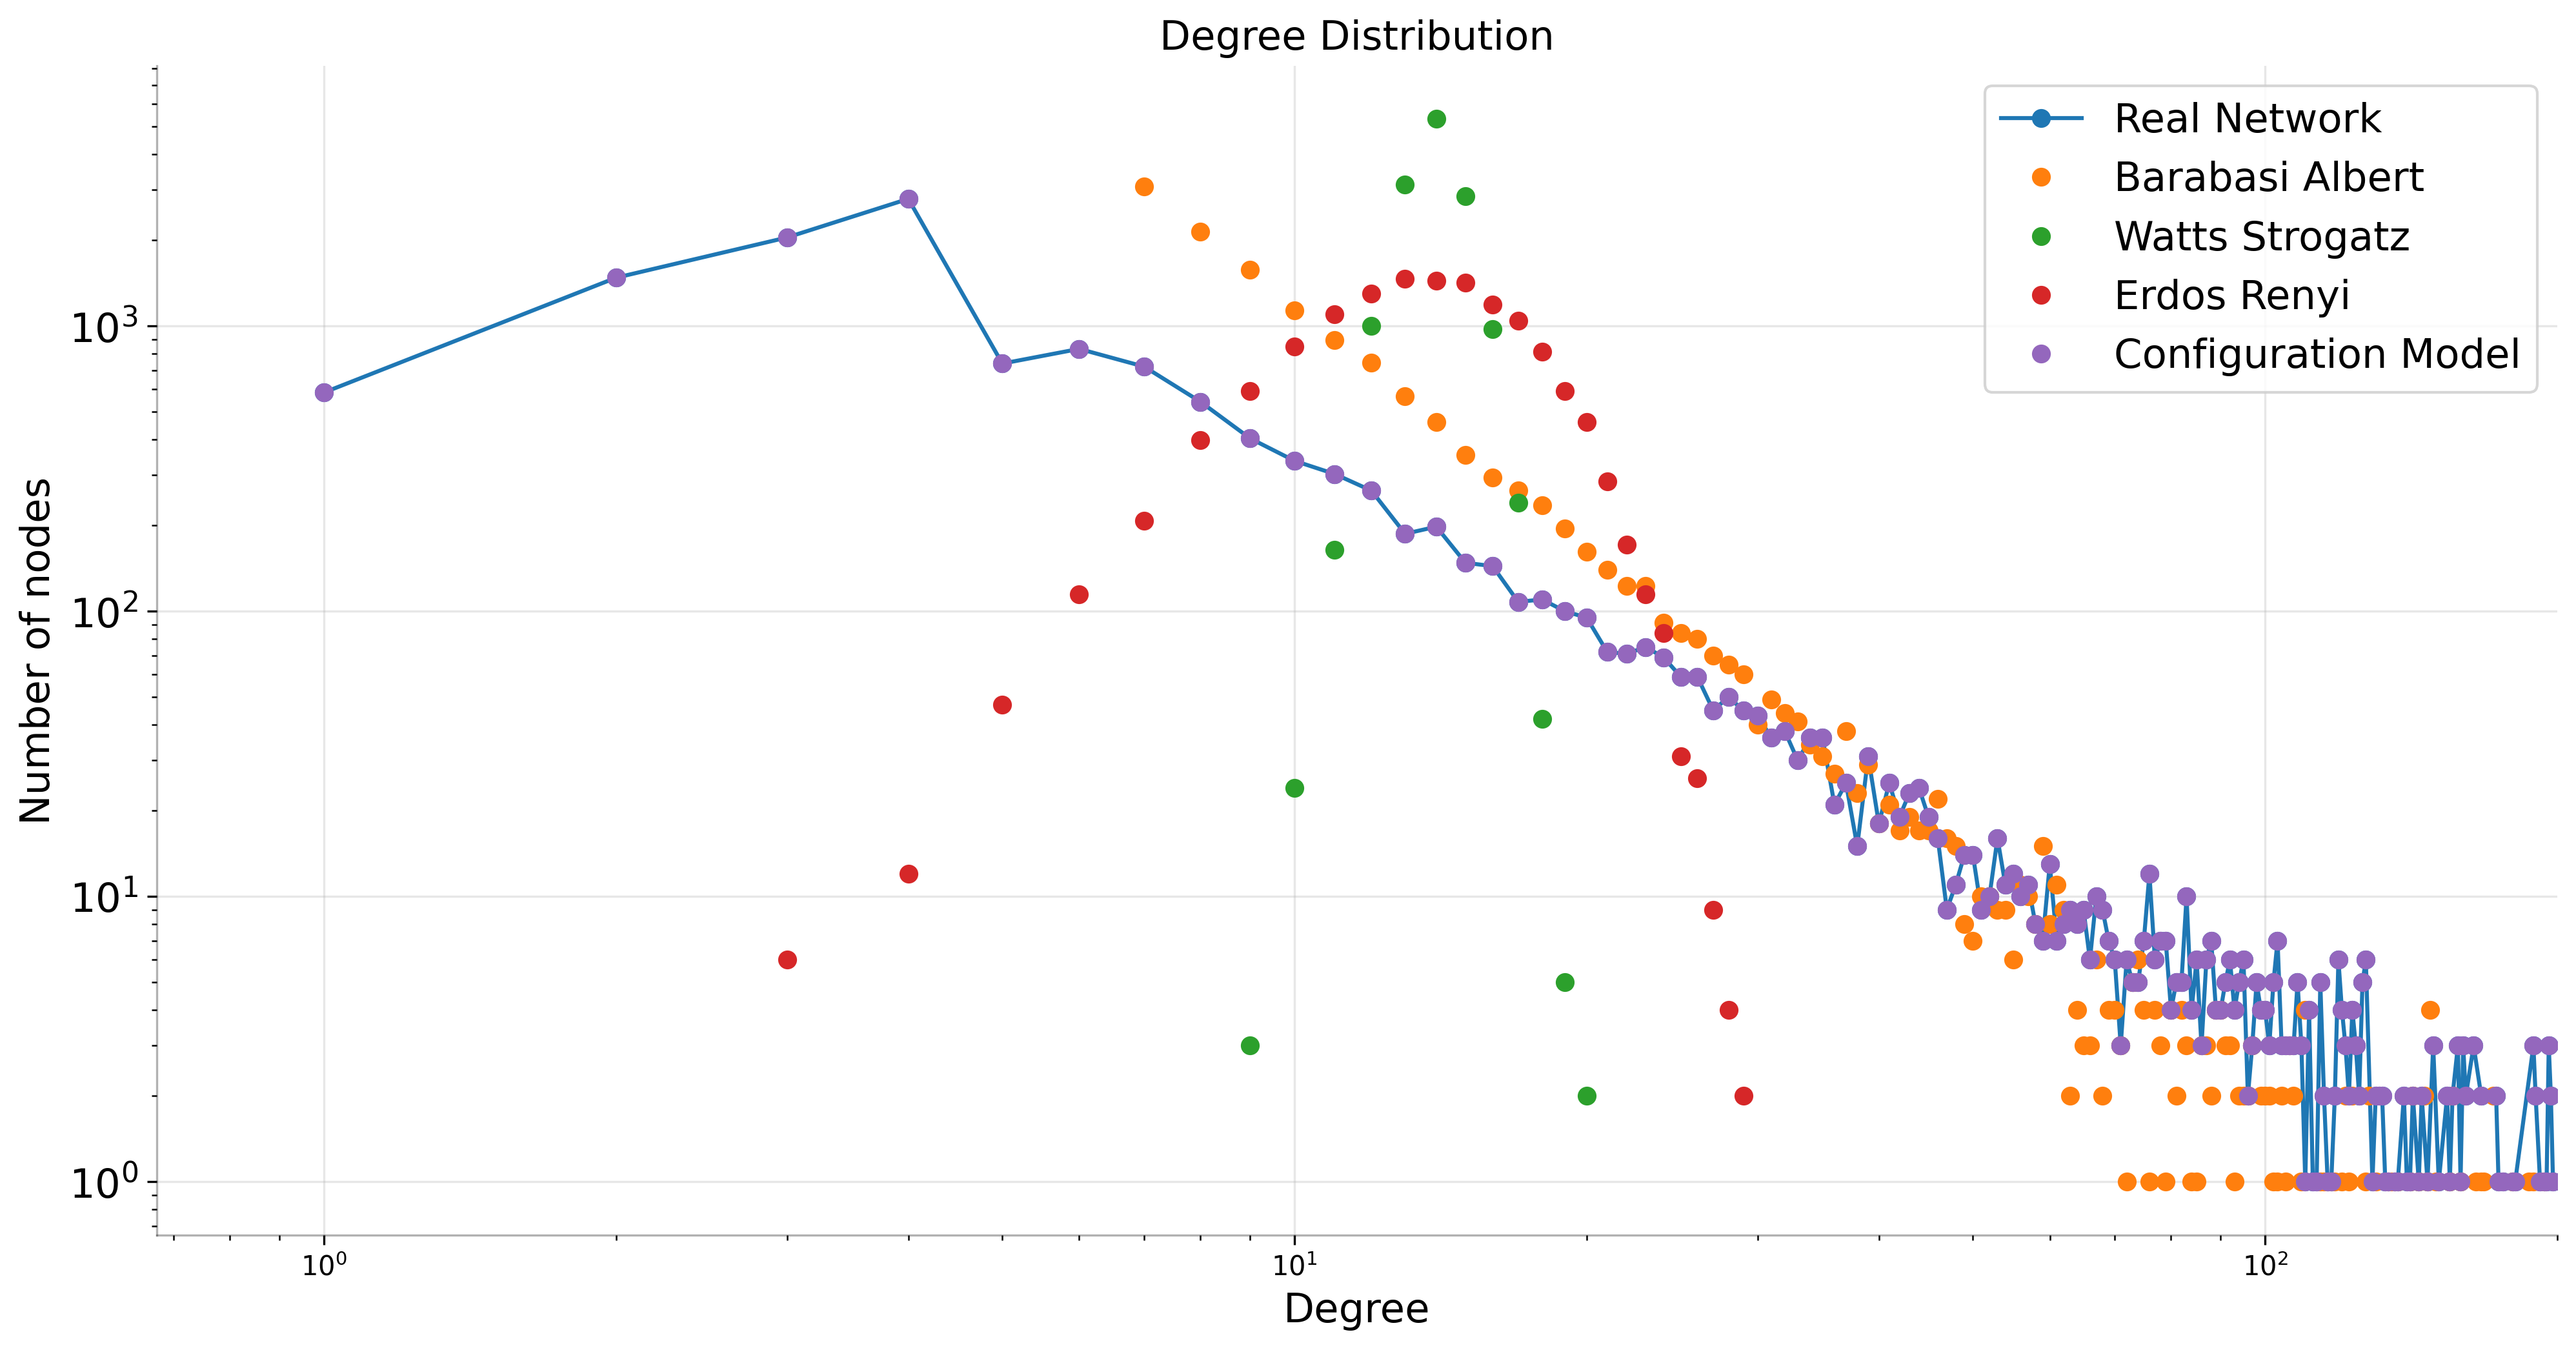

In [20]:
degree_dist_plot(models)

# 4 - Connected Components

In [7]:
def n_connected_components(G, name):
    print(f"**** Connected components for {name} graph ****")
    # list of connected components
    n_connected_component = list(nx.connected_components(G))
    print(f"Number of Connected Components for {name}: {len(n_connected_component)}")
    for i in range(len(n_connected_component)):
        if i < 3:
            print(f"\t component len = {len(n_connected_component[i])}")
    # Giant component -> Identify and store giant component
    H = nx.Graph()
    H = nx.subgraph(G,n_connected_component[0])
    nx.write_graphml(H, path_graph+"giant_component/"+ name+".graphml")
    return n_connected_component

In [18]:
components = n_connected_components(models["Real Network"], "Real Network")

**** Connected components for Real Network graph ****
Number of Connected Components for Real Network: 32
	 component len = 13699
	 component len = 4
	 component len = 2


# 5 - Path Analysis
Shortest Path

In [39]:
def path_analysis(G, name, components):
    print(f"***** Path analysis for {name} graph")
    print(f"Diameter for components 0 network {name}: {nx.diameter(G.subgraph(components[0]))}")
    print(f"Average shortest path for components 0 network {name}: {nx.average_shortest_path_length(G.subgraph(components[0]))}")
    

In [46]:
path_analysis(models["Real Network"], "Real Network", components)

***** Path analysis for Real Network graph
Diameter for components 0 network Real Network: 7
Average shortest path for components 0 network Real Network: 2.9687435314702775


In [19]:
print(f"Average shortest path for components 0 network Real Network weighted: {nx.average_shortest_path_length(G.subgraph(components[0]), weight='Count')}")

Average shortest path for components 0 network Real Network weighted: 3.3240668682409877


# 6 - Clustering Coefficient

## Average clustering coefficient

In [40]:
G_cc = nx.average_clustering(G)
print('Real world average cluster coefficient: ' + str(G_cc) + '\n')

Real world average cluster coefficient: 0.698890718451805



## Clustering coefficient distribution
The avarage clustering for the cm cannot be calculated because it is a multigraph (the function always returns a multigraph)

In [41]:
def degree_clustering(G, name):
    print(f"**** Distribution degree/clustering for {name} graph ***")
    degrees = G.degree()
    local_clustering_coefficient= []
    degree = []

    for d in degrees:
        local_clustering_coefficient.append(nx.clustering(G,d[0]))
        #print(local_clustering_coefficient)
        degree.append(d[1])
        
    plt.figure(figsize=(20,5))
    plt.scatter(degree, local_clustering_coefficient)

    plt.xlabel("k")
    plt.ylabel("C(k)")

    plt.show()

**** Distribution degree/clustering for Real Network graph ***


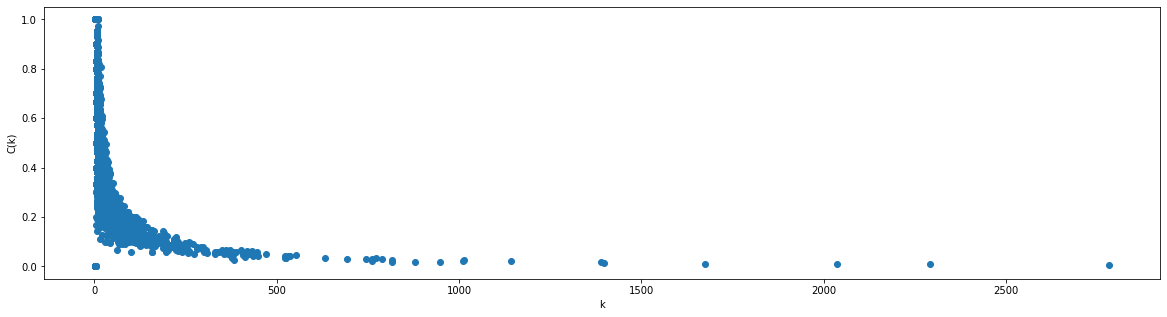

In [42]:
#for model in models:
#    degree_clustering(models[model], model)
degree_clustering(models["Real Network"], "Real Network")

In [43]:
def c_coefficient_analysis(G, name):
    clustering_g = nx.clustering(G)
    print(f"*** Clustering coefficient analysis for {name} graph ***")
    #print(f"CC: {clustering_g.values()}")
    print(f"Min: {min(clustering_g.values())}")
    print(f"Max: {max(clustering_g.values())}")
    print(f"Mean: {mean(clustering_g.values())}")
    print(f"Stdev: {stdev(clustering_g.values())}")
    return (name, clustering_g.values())

In [45]:
name, clustering_g = c_coefficient_analysis(models["Real Network"], "Real Network")

*** Clustering coefficient analysis for Real Network graph ***
Min: 0
Max: 1.0
Mean: 0.6988907184518008
Stdev: 0.32214539679723436
